# Ex 8

These exercises will introduce you to BLOBs and SIFT features. In this exercise you will write
the code for the blob detector as well as use the SIFT feature detector and matcher.
BLOB detector
You will implement a BLOB detector using the Difference-of-Gaussians (DoG) method and apply
it to the following image of sunflowers.
Start by loading the image into Python, and converting it to black and white and floating point.
im = im.astype(float).mean(2)/255

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy import ndimage
from scipy.spatial.transform import Rotation
from math import sqrt
from skimage import data
from skimage.feature import blob_dog
from skimage.color import rgb2gray
import utilis

(660, 1066)


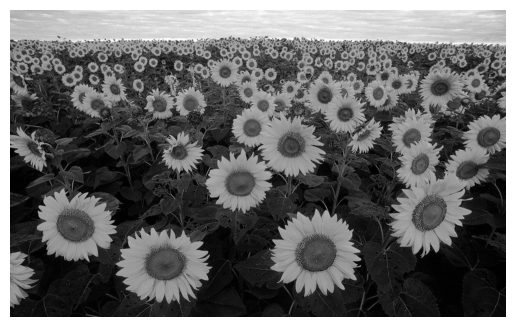

In [2]:
img = cv2.imread('images/sunflowers.jpg').astype(float).mean(2) / 255

plt.imshow(img, cmap="gray")
plt.axis("off")
print(img.shape)

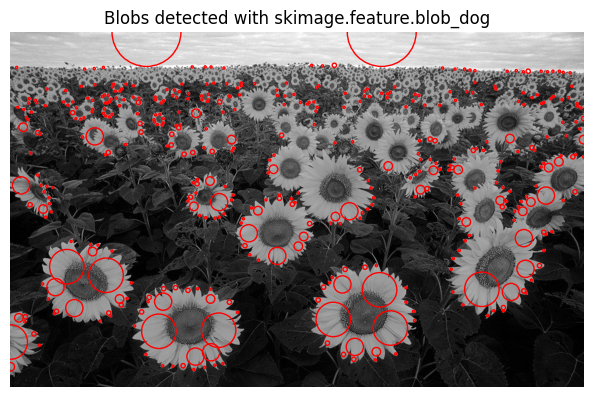

In [3]:
blobs_dog = blob_dog(
    img, min_sigma=2, max_sigma=128, sigma_ratio=2, threshold=0.1
)

plt.figure()
plt.imshow(img, cmap="gray")
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=1, fill=False)
    plt.gca().add_patch(c)
plt.tight_layout()
plt.axis("off")
plt.title("Blobs detected with skimage.feature.blob_dog")
plt.show()

#### 8.1 Scaling

Create the function ```im_scales = scaleSpaced(im, sigma, n)```, where im_scales is a scale pyramid of the original image im.  \
The width and height of all images in the pyramid im_scales are exactly the same as the original image im. In other words \
im_scales is *not a pyramid in image sizes; only in scale space*. 


This function should apply a Gaussian kernel of width $\sigma 2^i$, \
(where i = 0, 1, . . . , n − 1.)

**NB** This is providing the gaussians that we will then use to create DoG images used in blob detection!

Gaussian kernel

In [4]:
# Ex 8.1
def scale_spaced(im, sigma, n):
    """
    Naive implementation of the scale space pyramid with no downsampling.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        im_scales : list containing the scale space pyramid of the input image
        scales : list containing the scales used in the pyramid
    """
    scales = [sigma * 2**i for i in range(n)]  # ratio = 2
    im_scales = []
    im_scale = im
    for scale in scales:
        # Apply Gaussian filter on the previously scaled image
        g, _ = utilis.gaussian_1D_kernel(scale)
        im_scale = cv2.sepFilter2D(src=im_scale, ddepth=-1, kernelX=g, kernelY=g)
        im_scales.append(im_scale)
    return im_scales, scales

**NB** Two schools of though when it comes to the scale space: 

- Increase kernel size? If kernel size = 2*sigma, then we have already got like 97% of the distribution and we won't get much for increasing its size=> We have to scale the sigma proportionately.
- .. OR! just increase sigma. This is a lot more computationally efficient, and we still get 97%

im shape: (660, 1066)
scales: [5, 10, 20]


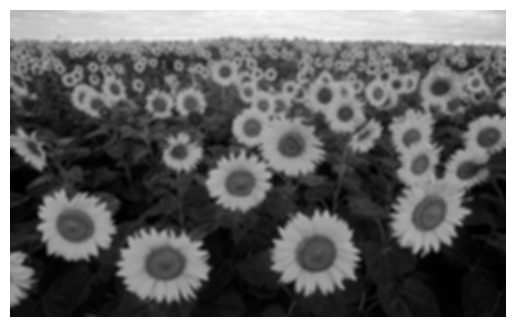

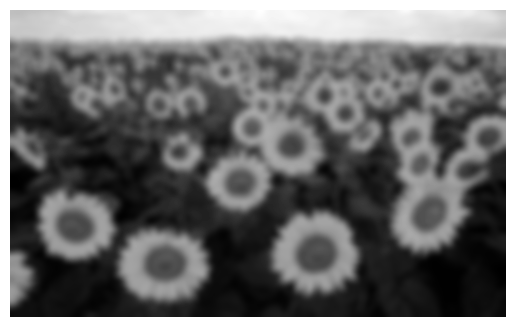

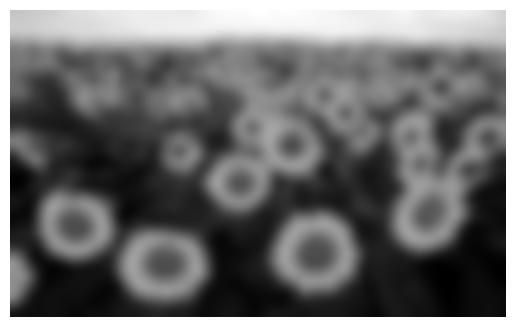

In [5]:
sigma = 5
n_scales = 3  # num of gaussians
im_scales, scales = scale_spaced(img, sigma, n_scales)

# Check images in pyramid are exactly the same as the original image
print(f"im shape: {im_scales[0].shape}")
print(f"scales: {scales}")

# Visualize images to check for progressive blur
for i, im_scale in enumerate(im_scales):
    plt.imshow(im_scale, cmap="gray")
    plt.axis("off")
    plt.show()
plt.show()

#### 8.2 DoG - Difference of gaussians

Now, create the function ```DoG = differenceOfGaussian(im, sigma, n)```, where DoG is the scale \
space DoGs of the original image im. Like the scaleSpaced function, the returned images are all 
the same size as the original.


In [6]:
def difference_of_gaussians(im, sigma, n):
    """
    Implementation of the difference of Gaussians.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales

    Returns:
        DoG : list of scale space DoGs of im
        scales : list containing the scales used in the pyramid
    """
    im_scales, scales = scale_spaced(im, sigma, n)
    DoG = []
    for i in range(1, n):
        diff = im_scales[i] - im_scales[i - 1]
        DoG.append(diff)
    return DoG, scales

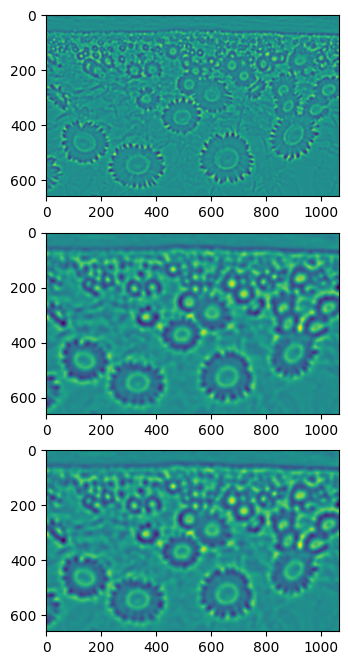

In [7]:
sigma = 5
n_scales = 3
DoG, scales = difference_of_gaussians(img, sigma, n_scales)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(4,8))
ax[0].imshow(DoG[0])
ax[1].imshow(DoG[1])
ax[2].imshow(DoG[1])
plt.show()

![alt text](images/image.png)

![alt text](<images/image copy.png>)
![alt text](<images/image copy 2.png>)

#### 8.3 Blob detection

Finally, create the function ```blobs = detectBlobs(im, sigma, n, threshold)```, where blobs are \
the blobs (pixels) of the original image im with a DoG larger than a threshold. You should also \
implement non-maximum suppression to increase the robustness of the detector. \
Try the detector on the image of sunflowers. Visualize your result by drawing a circle for each \
image, with the radius proportional to the scale of the blob. You can use cv2.circle for this.

Finding Extrema: Local extrema (minima and maxima) in the DoG images are identified as potential keypoints. These extrema are points that have higher or lower intensity than their neighbors in both the current and adjacent scales.

In [8]:
def non_maximum_suppression(data, order=1):
    """Detects local maxima in a 3D array

    params:
        : data : 3d ndarray
        : order : int
            How many points on each side to use for the comparison
    return:
        : coords : ndarray
            coordinates of the local maxima
        : values : ndarray
            values of the local maxima
    """
    size = 1 + 2 * order
    footprint = np.ones((size, size, size))
    footprint[order, order, order] = 0

    filtered = ndimage.maximum_filter(data, footprint=footprint)
    mask_local_maxima = data > filtered
    data[~mask_local_maxima] = 0
    
    return data

In [9]:
# Ex 8.3
def detect_blobs(im, sigma, n, tau):
    """
    Implementation of the blob detector.

    Args:
        im : input image
        sigma : standard deviation of the Gaussian kernel
        n : number of scales
        tau : threshold for blob detection

    Returns:
        blobs : list of detected blobs in the format (x, y, scale)
    """
    DoG, scales = difference_of_gaussians(im, sigma, n)
    DoG = np.array(DoG)

    # Obtain max value in a 3x3 neighborhood of each pixel in DoG
    MaxDoG = [cv2.dilate(abs(dog), np.ones((3, 3))) for dog in DoG] 

    # Thresholding & non-max suppression
    blobs = []
    prev_blobs = 0
    for i in range(len(DoG)):  # for each DoG

        if i==0:
            prev_MaxDoG = np.zeros(DoG[0].shape)
            next_MaxDoG = MaxDoG[i + 1]
        elif i==len(DoG)-1:
            prev_MaxDoG = MaxDoG[i - 1]
            next_MaxDoG = np.zeros(DoG[0].shape)
        else:
            prev_MaxDoG = MaxDoG[i - 1]
            next_MaxDoG = MaxDoG[i + 1]

        for j in range(im.shape[0]):  # for each row
            for k in range(im.shape[1]):  # for each column
                # take abs() to find max and min
                if (
                    abs(DoG[i][j, k]) > tau  # thresholding
                    and abs(DoG[i][j, k]) == MaxDoG[i][j, k] # max in current DoG
                    and abs(DoG[i][j, k]) > prev_MaxDoG[j, k] # max in previous DoG
                    and abs(DoG[i][j, k]) > next_MaxDoG[j, k] # max in next DoG
                ):
                    blobs.append((j, k, scales[i]))
        # Calculate how many new blobs detected in this DoG
        print(f"No. of blobs detected in DoG {i}: {len(blobs)-prev_blobs}")
        prev_blobs = len(blobs)
    return blobs


In [10]:
def visualize_blobs(blobs, im):
    """
    Args:
        blobs : list of detected blobs in the format (x, y, scale)
        im : BGR input image
    """
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # To draw colored shapes on a gray img
    bgr_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)  
    for x, y, scale in blobs:
        cv2.circle(
            bgr_img, (y, x), radius=int(scale), color=(255, 0, 0), thickness=2
        )
    plt.axis("off")
    plt.imshow(bgr_img)
    plt.show()

No. of blobs detected in DoG 0: 2197
No. of blobs detected in DoG 1: 406
No. of blobs detected in DoG 2: 174
No. of blobs detected in DoG 3: 76
No. of blobs detected in DoG 4: 34
No. of blobs detected in DoG 5: 15
Amount of blobs: 3
Mean value of maximas: 217.33333333333334
Total no. of blobs detected: 2902


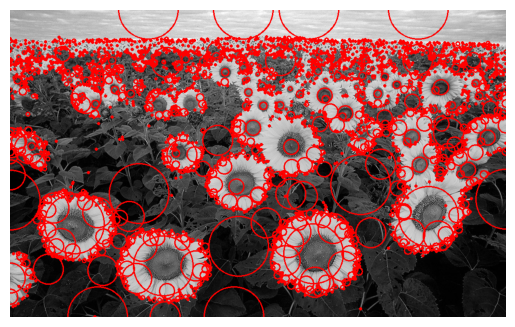

In [11]:
# blobs = detectBlobs(img, sigma=2, n=7, threshold=0.1)
# print("Amount of blobs:", len(blobs[0]))
# print("Mean value of maximas:", np.mean(blobs[3]))
sigma = 2
n_scales = 7
tau = 0.1
blobs = detect_blobs(img, sigma, n_scales, tau)
print("Amount of blobs:", len(blobs[0]))
print("Mean value of maximas:", np.mean(blobs[3]))
print(f"Total no. of blobs detected: {len(blobs)}")
visualize_blobs(blobs, cv2.imread("images/sunflowers.jpg"))

# Using SIFT

The SIFT feature detector and matcher are quite difficult to implement, so we will use existing \
implementations. However, first we need a good test case scenario.

#### 8.4 

Create the function ```r_im = transformIm(im, theta, s)```, where r_im is a scaled and rotated \
version of the original image im. In this case, theta is a rotation angle and s is a scale factor. \
Use this function to produce a transformed version of the test image r_im3.

In [12]:
# Ex 8.4
def transform_im(im, theta, s):
    """
    Rotate an image by theta degrees and scale by s.

    Args:
        im : input image
        theta : angle of rotation
        s : scaling factor

    Returns:
        r_im : rotated and scaled image
    """
    rows, cols = im.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), theta, s)
    r_im = cv2.warpAffine(im, M, (cols, rows))
    return r_im

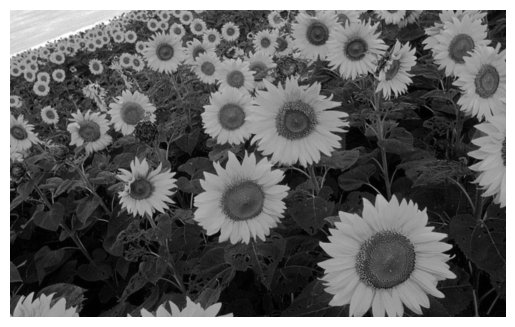

In [13]:
r_im = transform_im(img, 20, 1.5)
plt.imshow(r_im, cmap="gray")
plt.axis("off")
plt.show()

#### 8.5 SIFT detector

Use the SIFT detector to detect features in both the original and the transformed image. Plot the \
features on top of the images. There are quite a few parameters to play with. Try changing them \
and see the results. \
Now match the features to each other. For this you can use cv2.BFMatcher(). \
Plot the matches; do they look qualitatively correct? 

Filter your matches with the ratio test. Does this remove incorrect matches?

In [14]:
# Read images as uint8
# im_int = cv2.imread("images/sunflowers.jpg") .mean(2).astype(np.uint8)
im_int = cv2.imread("images/sunflowers.jpg")
im_int = cv2.cvtColor(im_int, cv2.COLOR_BGR2GRAY)
r_im_int = transform_im(im_int, 20, 1.5)

# SIFT detector
sift = cv2.SIFT_create()
kp1 = sift.detect(im_int, None)
kp2 = sift.detect(r_im_int, None)
 # Extract coordinates
kp1_coords = [kp.pt for kp in kp1]  # list of tuples (x, y)
kp2_coords = [kp.pt for kp in kp2]  # list of tuples (x, y)

# Print coordinates
print("Coordinates of keypoints in the original image:")
for i, coord in enumerate(kp1_coords):
    print(f"Keypoint {i + 1}: (x, y) = ({coord[0]}, {coord[1]})")


Coordinates of keypoints in the original image:
Keypoint 1: (x, y) = (2.395110607147217, 112.56846618652344)
Keypoint 2: (x, y) = (2.417039155960083, 121.42511749267578)
Keypoint 3: (x, y) = (2.417039155960083, 121.42511749267578)
Keypoint 4: (x, y) = (2.486595392227173, 424.5746765136719)
Keypoint 5: (x, y) = (2.7900006771087646, 287.955810546875)
Keypoint 6: (x, y) = (2.8137412071228027, 133.8468017578125)
Keypoint 7: (x, y) = (2.926478147506714, 210.14639282226562)
Keypoint 8: (x, y) = (3.0917749404907227, 78.01695251464844)
Keypoint 9: (x, y) = (3.328815221786499, 630.0501708984375)
Keypoint 10: (x, y) = (3.66300630569458, 139.1385498046875)
Keypoint 11: (x, y) = (3.695073366165161, 153.34266662597656)
Keypoint 12: (x, y) = (3.7401068210601807, 73.55142211914062)
Keypoint 13: (x, y) = (3.7902729511260986, 167.2051239013672)
Keypoint 14: (x, y) = (3.875722646713257, 185.5475311279297)
Keypoint 15: (x, y) = (3.875722646713257, 185.5475311279297)
Keypoint 16: (x, y) = (3.8757226467132

In [15]:
# Use SIFT to getkeypoints and their descriptors
sift = cv2.SIFT_create() # Sigma of the gaussian at octave 0
kp1, des1 = sift.detectAndCompute(im_int, None) #Keypoints and descriptors
kp2, des2 = sift.detectAndCompute(r_im_int, None) #Keypoints and descriptors

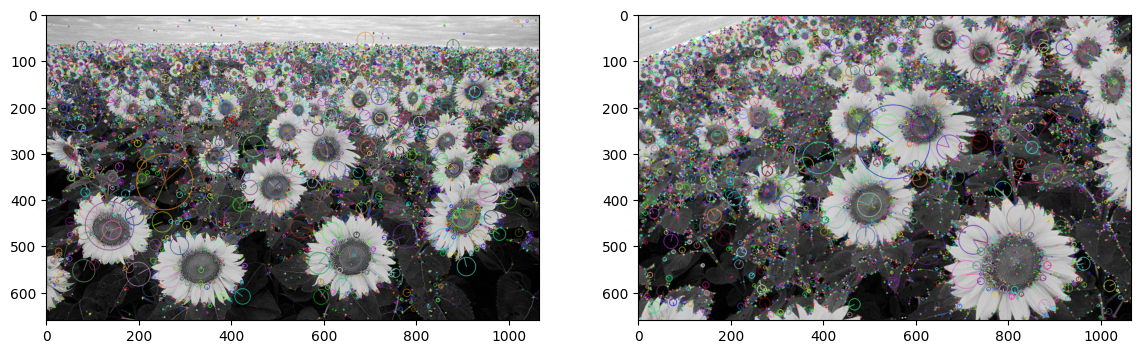

In [16]:
# Draw the keypoints on the images
kp1_img = cv2.drawKeypoints(im_int, kp1, im_int, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(r_im_int, kp2, r_im_int, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
axs[0].imshow(kp1_img, cmap="gray")
axs[1].imshow(kp2_img, cmap="gray")

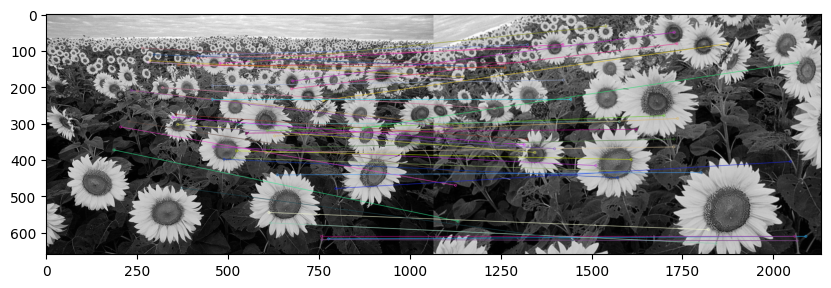

In [17]:
#Crosschecking, Brute-Force Matcher
bf = cv2.BFMatcher_create(crossCheck = True)
matches = bf.match(des1, des2)
sorted_matches = sorted(matches, key = lambda x:x.distance)



mimg = cv2.drawMatches(im_int, kp1, r_im_int, kp2, sorted_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg)

BEST MATCH

In [24]:
# Get indices and descriptor distance of the best match
best_match = min(matches, key=lambda x: x.distance)
img1_idx = best_match.queryIdx
img2_idx = best_match.trainIdx
best_match_distance = best_match.distance

# Get the coordinates of the best match
(x1, y1) = kp1[img1_idx].pt
(x2, y2) = kp2[img2_idx].pt

print(f"Best match between points ({x1}, {y1}) in image 1 and ({x2}, {y2}) in image 2 with distance: {best_match_distance}")

Best match between points (607.9425048828125, 321.01544189453125) in image 1 and (633.6908569335938, 279.0867919921875) in image 2 with distance: 12.409673690795898


In [18]:
for match in matches:
    # Get indices and descriptor distance
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    match_distance = match.distance
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    print(f"Match between points ({x1}, {y1}) in image 1 and ({x2}, {y2}) in image 2 with distance: {match_distance}")

Match between points (2.395110607147217, 112.56846618652344) in image 1 and (561.0316162109375, 489.02423095703125) in image 2 with distance: 282.80029296875
Match between points (2.417039155960083, 121.42511749267578) in image 1 and (93.25640106201172, 326.9361267089844) in image 2 with distance: 319.8421630859375
Match between points (2.486595392227173, 424.5746765136719) in image 1 and (1008.402587890625, 654.8527221679688) in image 2 with distance: 260.4534606933594
Match between points (3.7902729511260986, 167.2051239013672) in image 1 and (818.9597778320312, 26.67156410217285) in image 2 with distance: 296.05572509765625
Match between points (3.875722646713257, 185.5475311279297) in image 1 and (55.0234375, 194.97108459472656) in image 2 with distance: 269.0724792480469
Match between points (5.471680164337158, 399.0660705566406) in image 1 and (600.8174438476562, 14.7493257522583) in image 2 with distance: 198.3759002685547
Match between points (6.671604633331299, 92.678520202636

**Using sorted matches** the bf.match allows you to sort the matches so that only the closest matches are displayed.

**Filter matches** using the ratio test from the lecture, on the KNN matcher
- KNN matcher contains two and two matchees (best and second best)

((< cv2.DMatch 000001A96669B650>, < cv2.DMatch 000001A9675EB9F0>), (< cv2.DMatch 000001A96676C810>, < cv2.DMatch 000001A96676F850>), (< cv2.DMatch 000001A96676E750>, < cv2.DMatch 000001A96676EDD0>), (< cv2.DMatch 000001A96676EB90>, < cv2.DMatch 000001A96676E150>), (< cv2.DMatch 000001A96676E8F0>, < cv2.DMatch 000001A96676D1D0>), (< cv2.DMatch 000001A96676D110>, < cv2.DMatch 000001A96676D670>), (< cv2.DMatch 000001A96676DC50>, < cv2.DMatch 000001A96676F150>), (< cv2.DMatch 000001A96676C950>, < cv2.DMatch 000001A96676EA90>), (< cv2.DMatch 000001A96676FF70>, < cv2.DMatch 000001A96676D6D0>), (< cv2.DMatch 000001A96676D4F0>, < cv2.DMatch 000001A96676D130>), (< cv2.DMatch 000001A96676E0F0>, < cv2.DMatch 000001A96676E570>), (< cv2.DMatch 000001A96676FE90>, < cv2.DMatch 000001A96676F550>), (< cv2.DMatch 000001A96676DC10>, < cv2.DMatch 000001A96676E2F0>), (< cv2.DMatch 000001A96676F650>, < cv2.DMatch 000001A96676D170>), (< cv2.DMatch 000001A96676CAD0>, < cv2.DMatch 000001A96676CFB0>), (< cv2.DM

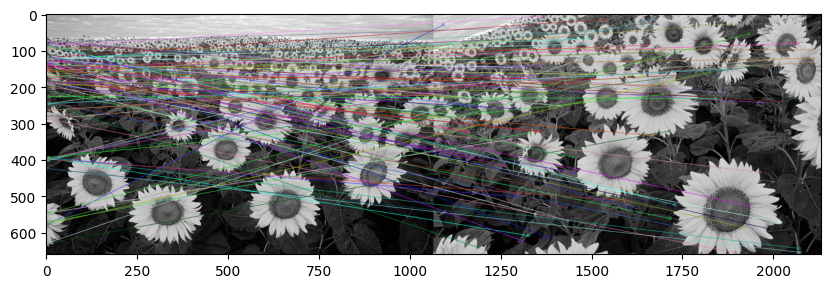

In [19]:
bf2 = cv2.BFMatcher()
matches_2 = bf2.knnMatch(des1,des2,k=2)
print(matches_2)

mimg_2 = cv2.drawMatchesKnn(im_int, kp1, r_im_int, kp2, matches_2[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg_2)

In [20]:
for match_pair in matches_2:
    for match in match_pair:  # Here match_pair is iterable, containing k DMatch objects
        # Get indices and descriptor distance
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        match_distance = match.distance

        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        print(f"Match from ({x1}, {y1}) to ({x2}, {y2}) with distance {match_distance}")

Match from (2.395110607147217, 112.56846618652344) to (561.0316162109375, 489.02423095703125) with distance 282.80029296875
Match from (2.395110607147217, 112.56846618652344) to (318.4736022949219, 614.5068359375) with distance 325.78521728515625
Match from (2.417039155960083, 121.42511749267578) to (93.25640106201172, 326.9361267089844) with distance 319.8421630859375
Match from (2.417039155960083, 121.42511749267578) to (429.1871337890625, 67.7857666015625) with distance 326.8791809082031
Match from (2.417039155960083, 121.42511749267578) to (93.35856628417969, 233.4487762451172) with distance 330.2741394042969
Match from (2.417039155960083, 121.42511749267578) to (186.06204223632812, 273.2824401855469) with distance 330.7763671875
Match from (2.486595392227173, 424.5746765136719) to (1008.402587890625, 654.8527221679688) with distance 260.4534606933594
Match from (2.486595392227173, 424.5746765136719) to (351.4795227050781, 575.3538818359375) with distance 265.39215087890625
Match f

In [21]:
# only keep matches that are distinctive enough
good = []
for m,n in matches_2:
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Distinctive matches:", len(good))

Distinctive matches: 2262


In [22]:
# Initialize a variable to store the best match if searching among all matches
best_match = None
min_distance = float('inf')  # Set initially to infinity

for match_pair in good:
    for match in match_pair:
        if match.distance < min_distance:
            min_distance = match.distance
            best_match = match

if best_match is not None:
    best_query_idx = best_match.queryIdx
    best_train_idx = best_match.trainIdx
    (best_x1, best_y1) = kp1[best_query_idx].pt
    (best_x2, best_y2) = kp2[best_train_idx].pt

    print(f"Best match: ({best_x1}, {best_y1}) in image 1 to ({best_x2}, {best_y2}) in image 2 with distance {best_match.distance}")

Best match: (607.9425048828125, 321.01544189453125) in image 1 to (633.6908569335938, 279.0867919921875) in image 2 with distance 12.409673690795898


**Conclusion**

Both sorting matches by distance and using ratio test worked really well in providing good matches, with only few misses.

WHY sift is invariant ? 
1. Scale Invariance
Pyramid Representation: SIFT uses a Difference of Gaussian (DoG) pyramid to detect keypoints. This pyramid is constructed by repeatedly smoothing the original image with Gaussian blurs and resizing it, creating images at different scales.
Keypoint Localization: For each pixel in the DoG images, SIFT compares the pixel with its neighbors across scales. Keypoints are selected based on their stability across multiple scales, ensuring that the same features can be recognized at different sizes.
2. Rotation Invariance
Orientation Assignment: Once keypoints are detected, each keypoint is assigned one or more orientations based on local image gradient directions. This assignment ensures that the keypoint descriptor is relative to this orientation, and hence the same feature can be recognized regardless of image rotation. \
Dominant Orientation: A histogram of gradient orientations is created, and the dominant orientation is assigned to the keypoint. This step makes the descriptor invariant to rotation.
3. Perspective Distortion (Affine Transformations) Invariance
Gradient Location and Magnitude: SIFT descriptors are based on the gradients' location and magnitude within a region around the keypoint, captured in a histogram. Even when the image undergoes affine transformations, leading to changes in the local appearance due to perspective, the gradient orientations adjust accordingly, allowing the descriptor to maintain consistency.
4. Noise Resistance
Local Extrema Detection: By using the DoG pyramid, SIFT effectively enhances contrast and suppresses potential noise by focusing on significant differences over scales, which tend to be more robust against fine-scale noise.
Detailed Keypoint Selector: The algorithm discards low-contrast keypoints and applies a threshold to the curvature of the scale-space function, removing keypoints that have a poor ratio of principal curvatures (often caused by noise).
5. Lighting Invariance
Descriptor Normalization: SIFT descriptors are normalized, reducing the effects of varying illumination. By normalizing the feature vector, changes in lighting that affect the gradient magnitudes are mitigated, allowing the algorithm to focus more on the gradient orientations relative to each keypoint.
6. Translation Invariance
Local Descriptors: Each SIFT descriptor is based on gradients calculated in a local neighborhood around the detected keypoint. The descriptor depends only on relative gradients, not on the absolute position of the keypoints in the image. Thus, if the entire image is translated, the local gradients around any point remain unchanged.